In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab10.ipynb")

# Lab 10: SQL

In this lab, we are going to practice viewing, sorting, grouping, and merging tables with SQL. We will explore two datasets:
1. A "minified" version of the [Internet Movie Database](https://www.imdb.com/interfaces/) (IMDb). This SQLite database (~10MB) is a tiny sample of the much larger database (more than a few GBs). As a result, disclaimer that we may get wildly different results than if we use the whole database!

1. The money donated during the 2016 election using the [Federal Election Commission (FEC)'s public records](https://www.fec.gov/data/). You will be connecting to a SQLite database containing the data. The data we will be working with in this lab is quite small (~16MB); however, it is a sample taken from a much larger database (more than a few GBs).


### Due Date

This assignment is due **Tuesday, April 5 at 11:59 pm PDT**.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

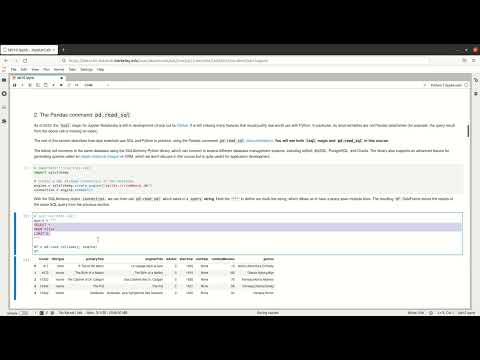

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("GxqpAEZP_kE", list = 'PLQCcNQgUcDfpdBnhS-lPq8LPas48tkMgp', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *Muqi*

In [3]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import plotly.express as px
import sqlalchemy
from ds100_utils import fetch_and_cache
from pathlib import Path  
%load_ext sql # add extension

# Unzip the data.
!unzip -o data.zip

Archive:  data.zip
  inflating: imdbmini.db             
  inflating: fec_nyc.db              


## SQL Query Syntax

Throughout this lab, you will become familiar with the following syntax for the `SELECT` query:

```
SELECT [DISTINCT] 
    {* | expr [[AS] c_alias] 
    {,expr [[AS] c_alias] ...}}
FROM tableref {, tableref}
[[INNER | LEFT ] JOIN table_name
    ON qualification_list]
[WHERE search_condition]
[GROUP BY colname {,colname...}]
[HAVING search condition]
[ORDER BY column_list]
[LIMIT number]
[OFFSET number of rows];
```

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 0 [Tutorial]: Writing SQL in Jupyter Notebooks

## 1. `%%sql` cell magic

In lecture, we used the `sql` extension to call **`%%sql` cell magic**, which enables us to connect to SQL databses and issue SQL commands within Jupyter Notebooks.

Run the below cell to connect to a mini IMDb database.

In [4]:
%sql sqlite:///imdbmini.db # connect to a mini IMDb database

<br/>

Above, prefixing our single-line command with `%sql` means that the entire line will be treated as a SQL command (this is called "line magic"). In this class we will most often write multi-line SQL, meaning we need "cell magic", where the first line has `%%sql` (note the double `%` operator).

The database `imdbmini.db` includes several tables, one of which is `Title`. Running the below cell will return first 5 lines of that table. Note that `%%sql` is on its own line.

We've also included syntax for single-line comments, which are surrounded by `--`.

In [5]:
%%sql
/*
 * This is a
 * multi-line comment.
 */
-- This is a single-line/inline comment. --
SELECT *
FROM Name
LIMIT 5;

 * sqlite:///imdbmini.db
Done.


nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"


<br/><br/>

### 2. The Pandas command `pd.read_sql`

As of 2022, the `%sql` magic for Jupyter Notebooks is still in development (check out its [GitHub](https://github.com/catherinedevlin/ipython-sql). It is still missing many features that would justify real-world use with Python. In particular, its returned tables are *not* Pandas dataframes (for example, the query result from the above cell is missing an index).

The rest of this section describes how data scientists use SQL and Python in practice, using the Pandas command `pd.read_sql` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html)). **You will see both `%sql` magic and `pd.read_sql` in this course**. 


The below cell connects to the same database using the SQLAlchemy Python library, which can connect to several different database management systems, including sqlite3, MySQL, PostgreSQL, and Oracle. The library also supports an advanced feature for generating queries called an [object relational mapper](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html) or ORM, which we won't discuss in this course but is quite useful for application development.

In [10]:
# important!!! run this cell
import sqlalchemy
from sqlalchemy import text

# create a SQL Alchemy connection to the database
engine = sqlalchemy.create_engine("sqlite:///imdbmini.db")
connection = engine.connect()

With the SQLAlchemy object `connection`, we can then call `pd.read_sql` which takes in a `query` **string**. Note the `"""` to define our multi-line string, which allows us to have a query span multiple lines. The resulting `df` DataFrame stores the results of the same SQL query from the previous section.

In [11]:
# just run this cell
query = """
SELECT *
FROM Title
LIMIT 5;
"""

df = pd.read_sql(text(query), connection)
df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
1,4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
2,10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
3,12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
4,13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


<br/>

**Long error messages**: Given that the SQL query is now in the string, the errors become more unintelligible. Consider the below (incorrect) query, which has a semicolon in the wrong place.

In [12]:
# uncomment the below code and check out the error

query = """
SELECT *
FROM Title;
LIMIT 5
"""
pd.read_sql(text(query), connection)

Warning: You can only execute one statement at a time.

<br/>

Now that's an unruly error message!

<br/><br/>

### 3. A suggested workflow for writing SQL in Jupyter Notebooks

Which approach is better, `%sql` magic or `pd.read_sql`?

The SQL database generally contains much more data than what you would analyze in detail. As a Python-fluent data scientist, you will often query SQL databases to perform initial exploratory data analysis, a subset of which you load into Python for further processing.

In practice, you would likely use a combination of the two approaches. First, you'd try out some SQL queries with `%sql` magic to get an interesting subset of data. Then, you'd copy over the query into a `pd.read_sql` command for visualization, modeling, and export with Pandas, sklearn, and other Python libraries.

For SQL assignments in this course, to minimize unruly error messages while maximizing Python compatibility, we suggest the following "sandboxed" workflow:
1. Create a `%%sql` magic cell **below** the answer cell. You can copy in the below code:

    ```
    %% sql
    -- This is a comment. Put your code here... --
    ```
<br/>

1.  Work on the SQL query in the `%%sql` cell; e.g., `SELECT ... ;`
1. Then, once you're satisfied with your SQL query, copy it into the multi-string query in the answer cell (the one that contains the `pd.read_sql` call).

You don't have to follow the above workflow to get full credit on assignments, but we suggest it to reduce debugging headaches. We've created the scratchwork `%%sql` cells for you in this assignment, but **do not** add cells between this `%%sql` cell and the Python cell right below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: The IMDb (mini) Dataset

Let's explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we will use for the upcoming homework.


Let's load in the database in two ways (using both Python and cell magic) so that we can flexibly explore the database.

In [13]:
engine = sqlalchemy.create_engine("sqlite:///imdbmini.db")
connection = engine.connect()

In [14]:
%sql sqlite:///imdbmini.db

<br/>

In [15]:
%%sql
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (text) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (integer) – in YYYY format
- deathYear (integer) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given tconst
- nconst (text) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- averageRating (real) – weighted average of all the individual user ratings
- numVotes (integer) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (text) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- year (YYYY) – represents the release year of a title.
- runtimeMinutes (integer)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1

What are the different kinds of `titleType`s included in the `Title` table? Write a query to find out all the unique `titleType`s of films using the `DISTINCT` keyword.  (**You may not use `GROUP BY`.**)

In [16]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --
SELECT DISTINCT titleType FROM Title;

 * sqlite:///imdbmini.db
Done.


titleType
short
movie
tvSeries
tvMovie
tvMiniSeries
video
videoGame
tvEpisode
tvSpecial


In [18]:
query_q1 = """
SELECT DISTINCT titleType FROM Title;
"""

res_q1 = pd.read_sql(text(query_q1), connection)
res_q1

,titleType
0,short
1,movie
2,tvSeries
3,tvMovie
4,tvMiniSeries
5,video
6,videoGame
7,tvEpisode
8,tvSpecial


In [19]:
grader.check("q1")

q1 results: All test cases passed!

---

## Question 2

Before we proceed we want to get a better picture of the kinds of jobs that exist.  To do this examine the `Role` table by computing the number of records with each job `category`.  Present the results in descending order by the total counts.

The top of your table should look like this (however, you should have more rows):

| |category|total|
|-----|-----|-----|
|**0**|actor|21665|
|**1**|writer|13830|
|**2**|...|...|

In [27]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --
SELECT category, COUNT(*) AS total FROM Role GROUP BY category ORDER BY total DESC;

 * sqlite:///imdbmini.db
Done.


category,total
actor,21665
writer,13830
actress,12175
producer,11028
director,6995
composer,4123
cinematographer,2747
editor,1558
self,623
production_designer,410


In [30]:
query_q2 = """
SELECT category, COUNT(*) AS total FROM Role GROUP BY category ORDER BY total DESC;
"""

res_q2 = pd.read_sql(text(query_q2), connection)
res_q2

,category,total
0,actor,21665
1,writer,13830
2,actress,12175
3,producer,11028
4,director,6995
5,composer,4123
6,cinematographer,2747
7,editor,1558
8,self,623
9,production_designer,410


In [31]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
If we computed the results correctly we should see a nice horizontal bar chart of the counts per category below:

In [34]:
# just run this cell
px.bar(res_q2, x="total", y="category", orientation='h')

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3

Now that we have a better sense of the basics of our data, we can ask some more interesting questions.

The `Rating` table has the `numVotes` and the `averageRating` for each title. Which 10 films have the most ratings?

Write a SQL query that outputs three fields: the `title`, `numVotes`, and `averageRating` for the 10 films that have the highest number of ratings.  Sort the result in descending order by the number of votes.

*Hint*: The `numVotes` in the `Rating` table is not an integer! Use `CAST(Rating.numVotes AS int) AS numVotes` to convert the attribute to an integer.

In [53]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --
SELECT primaryTitle AS title, CAST(numVotes AS int) AS numVotes, averageRating FROM Rating 
LEFT JOIN Title ON Title.tconst = Rating.tconst
ORDER BY numVotes DESC LIMIT 10;

 * sqlite:///imdbmini.db
Done.


title,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


In [52]:
%%sql
SELECT * FROM Title LIMIT 5;

 * sqlite:///imdbmini.db
Done.


tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
417,short,A Trip to the Moon,Le voyage dans la lune,0,1902,None,13,"Action,Adventure,Comedy"
4972,movie,The Birth of a Nation,The Birth of a Nation,0,1915,None,195,"Drama,History,War"
10323,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0,1920,None,76,"Fantasy,Horror,Mystery"
12349,movie,The Kid,The Kid,0,1921,None,68,"Comedy,Drama,Family"
13442,movie,Nosferatu,"Nosferatu, eine Symphonie des Grauens",0,1922,None,94,"Fantasy,Horror"


In [55]:
query_q3 = """
SELECT primaryTitle AS title, CAST(numVotes AS int) AS numVotes, averageRating FROM Rating 
LEFT JOIN Title ON Title.tconst = Rating.tconst
ORDER BY numVotes DESC LIMIT 10;
"""


res_q3 = pd.read_sql(text(query_q3), connection)
res_q3

,title,numVotes,averageRating
0,The Shawshank Redemption,2462686,9.3
1,The Dark Knight,2417875,9.0
2,Inception,2169255,8.8
3,Fight Club,1939312,8.8
4,Pulp Fiction,1907561,8.9
5,Forrest Gump,1903969,8.8
6,Game of Thrones,1874040,9.2
7,The Matrix,1756469,8.7
8,The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
9,The Lord of the Rings: The Return of the King,1709023,8.9


In [56]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 2: Election Donations in New York City

Finally, let's analyze the Federal Election Commission (FEC)'s public records. We connect to the database in two ways (using both Python and cell magic) so that we can flexibly explore the database.

In [57]:
# important!!! run this cell and the next one
import sqlalchemy
# create a SQL Alchemy connection to the database
engine = sqlalchemy.create_engine("sqlite:///fec_nyc.db")
connection = engine.connect()

In [58]:
%sql sqlite:///fec_nyc.db

## Table Descriptions

Run the below cell to explore the **schemas** of all tables saved in the database.

If you'd like, you can consult the below linked FEC pages for the descriptions of the tables themselves.

* `cand` ([link](https://www.fec.gov/campaign-finance-data/candidate-summary-file-description/)): Candidates table. Contains names and party affiliation.
* `comm` ([link](https://www.fec.gov/campaign-finance-data/committee-summary-file-description/)): Committees table. Contains committee names and types.
* `indiv_sample_nyc` ([link](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description)): All individual contributions from New York City .

In [60]:
%%sql
/* just run this cell */
SELECT sql FROM sqlite_master WHERE type='table';

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


sql
"CREATE TABLE ""cand"" ( cand_id character varying(9), cand_name text, cand_pty_affiliation character varying(3), cand_election_yr integer, cand_office_st character varying(2), cand_office character(1), cand_office_district integer, cand_ici character(1), cand_status character(1), cand_pcc character varying(9), cand_st1 text, cand_st2 text, cand_city text, cand_st character varying(2), cand_zip character varying(10))"
"CREATE TABLE ""comm""( ""cmte_id"" TEXT, ""cmte_nm"" TEXT, ""tres_nm"" TEXT, ""cmte_st1"" TEXT, ""cmte_st2"" TEXT, ""cmte_city"" TEXT, ""cmte_st"" TEXT, ""cmte_zip"" TEXT, ""cmte_dsgn"" TEXT, ""cmte_tp"" TEXT, ""cmte_pty_affiliation"" TEXT, ""cmte_filing_freq"" TEXT, ""org_tp"" TEXT, ""connected_org_nm"" TEXT, ""cand_id"" TEXT)"
"CREATE TABLE indiv_sample_nyc ( cmte_id character varying(9), amndt_ind character(1), rpt_tp character varying(3), transaction_pgi character(5), image_num bigint, transaction_tp character varying(3), entity_tp character varying(3), name text, city text, state character(2), zip_code character varying(12), employer text, occupation text, transaction_dt character varying(9), transaction_amt integer, other_id text, tran_id text, file_num bigint, memo_cd text, memo_text text, sub_id bigint)"


<br/><br/>

Let's look at the `indiv_sample_nyc` table. The below cell displays individual donations made by residents of the state of New York. We use `LIMIT 5` to avoid loading and displaying a huge table.

In [61]:
%%sql
/* just run this cell */
SELECT *
FROM indiv_sample_nyc
LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,100214505,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,100237940,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,101150010,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


You can write a SQL query to return the id and name of the first five candidates from the Democratic party, as below:

In [62]:
%%sql
/* just run this cell */
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cand_id,cand_name
H0AL05049,"CRAMER, ROBERT E ""BUD"" JR"
H0AL07086,"SEWELL, TERRYCINA ANDREA"
H0AL07094,"HILLIARD, EARL FREDERICK JR"
H0AR01091,"GREGORY, JAMES CHRISTOPHER"
H0AR01109,"CAUSEY, CHAD"


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## [Tutorial] Matching Text with `LIKE`

First, let's look at 2016 election contributions made by Donald Trump, who was a New York (NY) resident during that year. The following SQL query returns the `cmte_id`, `transaction_amt`, and `name` for every contribution made by any donor with "DONALD" and "TRUMP" in their name in the `indiv_sample_nyc` table.

Notes:
* We use the `WHERE ... LIKE '...'` to match fields with text patterns. The `%` wildcard represents at least zero characters. Compare this to what you know from regex!
* We use `pd.read_sql` syntax here because we will do some EDA on the result `res`.

In [64]:
# just run this cell
example_query = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%';
"""

example_res = pd.read_sql(text(example_query), connection)
example_res

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
152,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
153,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
154,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
155,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC


If we look at the list above, it appears that some donations were not by Donald Trump himself, but instead by an entity called "DONALD J TRUMP FOR PRESIDENT INC". Fortunately, we see that our query only seems to have picked up one such anomalous name.

In [65]:
# just run this cell
example_res['name'].value_counts()

TRUMP, DONALD J.                    133
DONALD J TRUMP FOR PRESIDENT INC     15
TRUMP, DONALD                         4
DONALD, TRUMP                         2
TRUMP, DONALD MR                      1
TRUMP, DONALD J MR.                   1
TRUMP, DONALD J MR                    1
Name: name, dtype: int64

<br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 4

Revise the above query so that the 15 anomalous donations made by "DONALD J TRUMP FOR PRESIDENT INC" do not appear. Your resulting table should have 142 rows. 

Hints:
* Consider using the above query as a starting point, or checking out the SQL query skeleton at the top of this lab. 
* The `NOT` keyword may also be useful here.


In [68]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND NOT name = "DONALD J TRUMP FOR PRESIDENT INC" LIMIT 10;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,transaction_amt,name
C00230482,2600,"DONALD, TRUMP"
C00230482,2600,"DONALD, TRUMP"
C00014498,9000,"TRUMP, DONALD"
C00494229,2000,"TRUMP, DONALD MR"
C00571869,2700,"TRUMP, DONALD J."
C00571869,2700,"TRUMP, DONALD J."
C00136457,5000,"TRUMP, DONALD"
C00034033,5000,"TRUMP, DONALD"
C00580100,4049,"TRUMP, DONALD J."
C00554949,2600,"TRUMP, DONALD J MR."


In [72]:
query_q4 = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND NOT name = "DONALD J TRUMP FOR PRESIDENT INC"
"""

res_q4 = pd.read_sql(text(query_q4), connection)
res_q4['name'].value_counts()

TRUMP, DONALD J.       133
TRUMP, DONALD            4
DONALD, TRUMP            2
TRUMP, DONALD MR         1
TRUMP, DONALD J MR.      1
TRUMP, DONALD J MR       1
Name: name, dtype: int64

In [73]:
grader.check("q4")

q4 results: All test cases passed!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 5: `JOIN`ing Tables

Let's explore the other two tables in our database: `cand` and `comm`.

The `cand` table contains summary financial information about each candidate registered with the FEC or appearing on an official state ballot for House, Senate or President.

In [74]:
%%sql
/* just run this cell */
SELECT *
FROM cand
LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054
H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5,,P,C00239038,PO BOX 2621,,HUNTSVILLE,AL,35804
H0AL05163,"BROOKS, MO",REP,2016,AL,H,5,I,C,C00464149,7610 FOXFIRE DRIVE,,HUNTSVILLE,AL,35802


The `comm` table contains summary financial information about each committee registered with the FEC. Committees are organizations that spend money for political action or parties, or spend money for or against political candidates.

In [75]:
%%sql
/* just run this cell */
SELECT *
FROM comm
LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


---

### Question 5a

Notice that both the `cand` and `comm` tables have a `cand_id` column. Let's try joining these two tables on this column to print out committee information for candidates.

List the first 5 candidate names (`cand_name`) in reverse lexicographic order by `cand_name`, along with their corresponding committee names. **Only select rows that have a matching `cand_id` in both tables.**

Your output should look similar to the following:

|    |cand_name|cmte_nm|
|----|----|----|
|**0**|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|**1**|ZUMWALT, JAMES|ZUMWALT FOR CONGRESS|
|**...**|...|...|

Consider starting from the following query skeleton, which uses the `AS` keyword to rename the `cand` and `comm` tables to `c1` and `c2`, respectively.
Which join is most appropriate?

    SELECT ...
    FROM cand AS c1
        [INNER | {LEFT |RIGHT | FULL } {OUTER}] JOIN comm AS c2
        ON ...
    ...
    ...;


In [91]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --
SELECT c1.cand_name, c2.cmte_nm
FROM cand AS c1
INNER JOIN comm AS c2
ON c1.cand_id = c2.cand_id
ORDER BY c1.cand_name DESC
LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cand_name,cmte_nm
"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


In [85]:
%%sql
SELECT * FROM cand LIMIT 3;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054


In [86]:
%%sql
SELECT * FROM comm LIMIT 3;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,


In [93]:
query_q5a = """
SELECT c1.cand_name, c2.cmte_nm
FROM cand AS c1
INNER JOIN comm AS c2
ON c1.cand_id = c2.cand_id
ORDER BY c1.cand_name DESC
LIMIT 5;
"""

res_q5a = pd.read_sql(text(query_q5a), connection)
res_q5a

,cand_name,cmte_nm
0,"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
1,"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
2,"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
3,"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
4,"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


In [94]:
grader.check("q5a")

q5a results: All test cases passed!

<br/><br/>

---

### Question 5b

Suppose we modify the query from the previous part to include *all* candidates, **including those that don't have a committee.**


List the first 5 candidate names (`cand_name`) in reverse lexicographic order by `cand_name`, along with their corresponding committee names. If the candidate has no committee in the `comm` table, then `cmte_nm` should be NULL (or None in the Python representation).

Your output should look similar to the following:

|    |cand_name|cmte_nm|
|----|----|----|
|**0**|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|**...**|...|...|
|**4**|ZORNOW, TODD MR|None|

Hint: Start from the same query skeleton as the previous part. 
Which join is most appropriate?

In [64]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --


In [96]:
query_q5b = """
SELECT c1.cand_name, c2.cmte_nm
FROM cand AS c1
LEFT JOIN comm AS c2
ON c1.cand_id = c2.cand_id
ORDER BY c1.cand_name DESC
LIMIT 5;
"""

res_q5b = pd.read_sql(text(query_q5b), connection)
res_q5b

,cand_name,cmte_nm
0,"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
1,"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
2,"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
3,"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
4,"ZORNOW, TODD MR",None


In [97]:
grader.check("q5b")

q5b results: All test cases passed!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 6: Subqueries and Grouping

If we return to our results from Question 4, we see that many of the contributions were to the same committee:

In [98]:
# Your SQL query result from Question 4
# reprinted for your convenience
res_q4

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
137,C00580100,9752,"TRUMP, DONALD J."
138,C00580100,2574,"TRUMP, DONALD J."
139,C00580100,23775,"TRUMP, DONALD J."
140,C00580100,2000000,"TRUMP, DONALD J."


<br/>

---

Create a new SQL query that returns the total amount that Donald Trump contributed to each committee.

Your table should have four columns: `cmte_id`, `total_amount` (total amount contributed to that committee), `num_donations` (total number of donations), and `cmte_nm` (name of the committee). Your table should be sorted in **decreasing order** of `total_amount`.

**This is a hard question!** Don't be afraid to reference the lecture slides, or the overall SQL query skeleton at the top of this lab.

Here are some other hints:

* Note that committee names are not available in `indiv_sample_nyc`, so you will have to obtain information somehow from the `comm` table (perhaps a `JOIN` would be useful).
* Remember that you can compute summary statistics after grouping by using aggregates like `COUNT(*)`, `SUM()` as output fields.
* A **subquery** may be useful to break your question down into subparts. Consider the following query skeleton, which uses the `WITH` operator to store a subquery's results in a temporary table named `donations`.

        WITH donations AS (
            SELECT ...
            ...
        )
        SELECT ...
        FROM donations
        GROUP BY ...
        ORDER BY ...;

In [112]:
%%sql
WITH donations AS (
    SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND NOT name = "DONALD J TRUMP FOR PRESIDENT INC"
)
SELECT donations.cmte_id, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations, cmte_nm  
FROM donations
LEFT JOIN comm 
ON donations.cmte_id = comm.cmte_id
GROUP BY donations.cmte_id
ORDER BY cmte_nm DESC;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,total_amount,num_donations,cmte_nm
C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC
C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
C00014498,9000,1,REPUBLICAN PARTY OF IOWA
C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
C00494229,2000,1,HELLER FOR SENATE
C00230482,5200,2,GRASSLEY COMMITTEE INC
C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
C00571869,5400,2,DONOVAN FOR CONGRESS
C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."


In [113]:
%%sql 
SELECT * FROM comm LIMIT 5;

 * sqlite:///fec_nyc.db
   sqlite:///imdbmini.db
Done.


cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


In [70]:
%%sql
/*
 * Code in this scratchwork cell is __not graded.__
 * Copy over any SQL queries you write here into the below Python cell.
 * Do __not__ insert any new cells in between the SQL/Python cells!
 * Doing so may break the autograder.
 */
-- Write below this comment. --


In [114]:
query_q6 = """
WITH donations AS (
    SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND NOT name = "DONALD J TRUMP FOR PRESIDENT INC"
)
SELECT donations.cmte_id, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations, cmte_nm  
FROM donations
LEFT JOIN comm 
ON donations.cmte_id = comm.cmte_id
GROUP BY donations.cmte_id
ORDER BY cmte_nm DESC;
"""


res_q6 = pd.read_sql(text(query_q6), connection)
res_q6

,cmte_id,total_amount,num_donations,cmte_nm
0,C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC
1,C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
2,C00014498,9000,1,REPUBLICAN PARTY OF IOWA
3,C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
4,C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
5,C00494229,2000,1,HELLER FOR SENATE
6,C00230482,5200,2,GRASSLEY COMMITTEE INC
7,C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
8,C00571869,5400,2,DONOVAN FOR CONGRESS
9,C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."


In [115]:
grader.check("q6")

q6 results: All test cases passed!

# Congratulations! You finished the lab!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [116]:
grader.check_all()

q1 results: All test cases passed!

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q5a results: All test cases passed!

q5b results: All test cases passed!

q6 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)